# Non-DC ML water masks creation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob
import shutil
from datetime import datetime
import pandas as pd
import time
import os

from subprocess import Popen, PIPE, STDOUT

# from utils.genprepWater import per_scene_wofs
from utils.prep_utils import s3_list_objects_paths, conv_sgl_cog

from utils.genprepMLWater import genprepmlwater

In [3]:
# # should encode to env vars as with docker, not csv
print(os.environ['AWS_ACCESS_KEY_ID'])
print(os.environ['AWS_S3_ENDPOINT_URL'])

16c353e3c1673eb9556e
http://s3-uk-1.sa-catapult.co.uk


# **Example job**

essential **input vars**

In [4]:
# essential input vars
s3_bucket = 'public-eo-data'
s3_dir = 'common_sensing/tom/mlperscene_test8/'
inter_dir = '../data/'

find **list of scene yamls** - this is essentially input to the job list

In [5]:
%%time
s3_dir_allprods = 'common_sensing/fiji/'
# prep to single yaml path
s3_paths = s3_list_objects_paths(s3_bucket, s3_dir_allprods)
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']
len(yamls)

CPU times: user 44.1 s, sys: 1.36 s, total: 45.4 s
Wall time: 1min 7s


16681

filter to **yamls of test scenes** - i.e. scenes from desired sensors that are largely spatially covered by and within preceeding year to Annual Wofs Water Summary test aoi and year

In [6]:
ys = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']
print("YEAR  |  L7  |  L8  |  S2  |  S1")
for y in ys:
    l7_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'landsat_7') & ('074072' in i) & (y == i.split('/')[3].split('_')[-1][:4])])
    l8_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'landsat_8') & ('074072' in i) & (y == i.split('/')[3].split('_')[-1][:4])])
    s2_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'sentinel_2') & ('60KXF' in i ) & (y in i)])
    s1_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'sentinel_1') & (y in i)])
    
    print(y, len(l7_ymls), len(l8_ymls), len(s2_ymls), len(s1_ymls))

YEAR  |  L7  |  L8  |  S2  |  S1
2000 6 0 0 0
2001 11 0 12 9
2002 7 0 12 8
2003 7 0 12 7
2004 13 0 9 11
2005 12 0 0 1
2006 14 0 0 0
2007 8 0 0 0
2008 11 0 0 0
2009 10 0 0 0
2010 16 0 0 0
2011 7 0 4 0
2012 15 0 0 0
2013 14 15 0 0
2014 0 22 0 10
2015 0 23 0 37
2016 0 22 2 41
2017 0 23 33 78
2018 0 23 172 90
2019 0 23 146 89
2020 0 6 45 36


In [7]:
# l8_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'landsat_8') & ('074072' in i) & ('2019' == i.split('/')[3].split('_')[-1][:4])])
# s2_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'sentinel_2') & ('60KXF' in i ) & ('2019' in i)])
# l7_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'landsat_7') & ('074072' in i) & ('2013' == i.split('/')[3].split('_')[-1][:4])])
# s1_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'sentinel_1') & ('2019' in i)])
# len(s1_ymls), len(l8_ymls), len(s2_ymls), len(l7_ymls)


(89, 23, 145, 14)

In [9]:
l8_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'landsat_8') ])
s2_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'sentinel_2') ])
l7_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'landsat_7') ])
s1_ymls = sorted([i for i in yamls if (i.split('/')[2] == 'sentinel_1') ])
len(s1_ymls), len(l8_ymls), len(s2_ymls), len(l7_ymls)


(381, 2764, 6979, 1549)

filter yamls to find list of **available annual water summary** products

In [19]:
wofssummary_ymls = [i for i in yamls if (i.split('/')[2] == 'wofs_summary') & ('2013' in i)]
len(wofssummary_ymls)

1

grab example from each sensor

In [9]:
l = [s1_ymls[1],s2_ymls[2],l8_ymls[1],l7_ymls[1]]
for i in l: 
    print(i)

common_sensing/fiji/sentinel_1/S1A_IW_GRDH_1SDV_20190103T174045/datacube-metadata.yaml
common_sensing/fiji/sentinel_2/S2A_MSIL2A_20190114T221941_T60KXF/datacube-metadata.yaml
common_sensing/fiji/landsat_8/LC08_L1TP_074072_20190129/datacube-metadata.yaml
common_sensing/fiji/landsat_7/LE07_L1TP_074072_20130120/datacube-metadata.yaml


In [10]:
wofssummary_ymls[0].replace('20130101_20140101','20180101_20190101')

'common_sensing/fiji/wofs_summary/wofssummary_20180101_20190101/datacube-metadata.yaml'

In [ ]:
rpush jobMLWater '{"img_yml_path": "common_sensing/fiji/sentinel_2/S2A_MSIL2A_20190114T221941_T60KXF/datacube-metadata.yaml", "lab_yml_path": "common_sensing/fiji/wofs_summary/wofssummary_20180101_20190101/datacube-metadata.yaml", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/mlwater_finaltest/"}'

In [10]:
td = datetime.today()
td = td.strftime('%Y')+td.strftime('%m')+td.strftime('%d')

In [13]:
f"{inter_dir}JOBLIST_{td}_MLWater.txt"

'../data/JOBLIST_20200604_MLWater.txt'

In [20]:
wofssummary_ymls

['common_sensing/fiji/wofs_summary/wofssummary_20130101_20140101/datacube-metadata.yaml']

In [22]:
la = wofssummary_ymls[0].replace('20130101_20140101','20180101_20190101')
la

'common_sensing/fiji/wofs_summary/wofssummary_20180101_20190101/datacube-metadata.yaml'

In [24]:
for i in l8_ymls[:1]:
    print("rpush jobMLWater"+" '{"+'"img_yml_path": "'+ i +'", "lab_yml_path": "'+ la +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/mlwatermasks/"'+"}'" + '\n')

rpush jobMLWater '{"img_yml_path": "common_sensing/fiji/landsat_8/LC08_L1TP_072069_20130522/datacube-metadata.yaml", "lab_yml_path": "common_sensing/fiji/wofs_summary/wofssummary_20180101_20190101/datacube-metadata.yaml", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/mlwatermasks/"}'



In [26]:
inter_dir

'../data/'

In [31]:
d = "/tmp/data/"

In [32]:
with open(f"{d}JOBLIST_{td}_MLWater_L8.txt", 'a') as t:
    for i in l8_ymls:
        t.write("rpush jobMLWater"+" '{"+'"img_yml_path": "'+ i +'", "lab_yml_path": "'+ la +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/mlwatermasks/"'+"}'" + '\n')

In [34]:
with open(f"{d}JOBLIST_{td}_MLWater_L7.txt", 'a') as t:
    for i in l7_ymls:
        t.write("rpush jobMLWater"+" '{"+'"img_yml_path": "'+ i +'", "lab_yml_path": "'+ la +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/mlwatermasks/"'+"}'" + '\n')

In [33]:
with open(f"{d}JOBLIST_{td}_MLWater_S1.txt", 'a') as t:
    for i in s1_ymls:
        t.write("rpush jobMLWater"+" '{"+'"img_yml_path": "'+ i +'", "lab_yml_path": "'+ la +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/mlwatermasks/"'+"}'" + '\n')

In [35]:
with open(f"{d}JOBLIST_{td}_MLWater_S2.txt", 'a') as t:
    for i in s2_ymls:
        t.write("rpush jobMLWater"+" '{"+'"img_yml_path": "'+ i +'", "lab_yml_path": "'+ la +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/mlwatermasks/"'+"}'" + '\n')

example **job function**

In [13]:
img_yml_path = l8_ymls[-2]
lab_yml_path = wofssummary_ymls[0]
# optical_yaml_path = s2_ymls[8]
# optical_yaml_path = s1_ymls[8]
# summary_yaml_path = wofssummary_ymls[0]
img_yml_path, lab_yml_path

('common_sensing/fiji/landsat_8/LC08_L1TP_074072_20191215/datacube-metadata.yaml',
 'common_sensing/fiji/wofs_summary/wofssummary_20130101_20140101/datacube-metadata.yaml')

In [15]:
genprepmlwater(img_yml_path, lab_yml_path, s3_bucket=s3_bucket, s3_dir=s3_dir, inter_dir=inter_dir)

INFO:root:LC08_L1TP_074072_20191215 Starting
INFO:root:LC08_L1TP_074072_20191215 Finding & Streaming Image & Labels Yamls
INFO:root:LC08_L1TP_074072_20191215 Found & access yamls
INFO:root:LC08_L1TP_074072_20191215 Loading & Reformatting bands
ERROR:root:LC08_L1TP_074072_20191215 Band data not loaded properly
Traceback (most recent call last):
  File "/opt/notebooks/utils/genprepMLWater.py", line 258, in genprepmlwater
    xr_data = load_img(bands_data, bands)
  File "/opt/notebooks/utils/genprepMLWater.py", line 74, in load_img
    bands_data = [ bands_data[i].rio.reproject_match(bands_data[0]) for i in range(len(band_nms)) ] # repro+resample+extent
  File "/opt/notebooks/utils/genprepMLWater.py", line 74, in <listcomp>
    bands_data = [ bands_data[i].rio.reproject_match(bands_data[0]) for i in range(len(band_nms)) ] # repro+resample+extent
  File "/opt/conda/lib/python3.7/site-packages/rioxarray/rioxarray.py", line 983, in reproject_match
    resampling=resampling,
  File "/opt/cond

boo


In [17]:
for sc in l[:]:
    print(l)
    genprepmlwater(sc, wofssummary_ymls[0].replace('20130101_20140101','20180101_20190101'), s3_bucket=s3_bucket, s3_dir=s3_dir, inter_dir=inter_dir)

INFO:root:LC08_L1TP_074072_20190129 Starting
INFO:root:LC08_L1TP_074072_20190129 Finding & Streaming Image & Labels Yamls
INFO:root:LC08_L1TP_074072_20190129 Found & access yamls
INFO:root:LC08_L1TP_074072_20190129 Loading & Reformatting bands


['common_sensing/fiji/sentinel_1/S1A_IW_GRDH_1SDV_20190103T174045/datacube-metadata.yaml', 'common_sensing/fiji/sentinel_2/S2A_MSIL2A_20190114T221941_T60KXF/datacube-metadata.yaml', 'common_sensing/fiji/landsat_8/LC08_L1TP_074072_20190129/datacube-metadata.yaml', 'common_sensing/fiji/landsat_7/LE07_L1TP_074072_20130120/datacube-metadata.yaml']


INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:root:LC08_L1TP_074072_20190129 Applying masks
INFO:root:LC08_L1TP_074072_20190129 Training
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  1.1min finished
INFO:root:LC08_L1TP_074072_20190129 Prediction
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    7.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    7.4s finished
INFO:root:LC08_L1TP_074072_20190129 Exporting water product
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:root:LC08_L1TP_074072_20190129 Creating yaml
DEBUG:root:in get geometry ../data/LC08_L1TP_074072_20190129_tmp/LC08_L1TP_074072_20190129_ml

Preparing scene LC08_L1TP_074072_20190129_mlwater
Scene path ../data/LC08_L1TP_074072_20190129_tmp/LC08_L1TP_074072_20190129_mlwater/
{'watermask': {'path': 'LC08_L1TP_074072_20190129_watermask.tif'}, 'waterprob': {'path': 'LC08_L1TP_074072_20190129_waterprob.tif'}}
{'spatial_reference': 'PROJCS["WGS 84 / UTM zone 60N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",177],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32660"]]', 'geo_ref_points': {'ul': {'x': 586200.0, 'y': -1802100.0}, 'ur': {'x': 816900.0, 'y': -1802100.0}, 'll': {'x'

DEBUG:root:Endpoint URL: http://s3-uk-1.sa-catapult.co.uk
INFO:root:Local source file: ../data/LC08_L1TP_074072_20190129_tmp/LC08_L1TP_074072_20190129_mlwater/datacube-metadata.yaml
INFO:root:S3 target file: common_sensing/tom/mlperscene_test8/LC08_L1TP_074072_20190129_mlwater/datacube-metadata.yaml
INFO:root:Start: ../data/LC08_L1TP_074072_20190129_tmp/LC08_L1TP_074072_20190129_mlwater/datacube-metadata.yaml 2020-05-21 13:52:49
INFO:root:Finish: ../data/LC08_L1TP_074072_20190129_tmp/LC08_L1TP_074072_20190129_mlwater/datacube-metadata.yaml 2020-05-21 13:52:49
DEBUG:root:Endpoint URL: http://s3-uk-1.sa-catapult.co.uk
INFO:root:Local source file: ../data/LC08_L1TP_074072_20190129_tmp/LC08_L1TP_074072_20190129_mlwater/LC08_L1TP_074072_20190129_watermask.tif
INFO:root:S3 target file: common_sensing/tom/mlperscene_test8/LC08_L1TP_074072_20190129_mlwater/LC08_L1TP_074072_20190129_watermask.tif
INFO:root:Start: ../data/LC08_L1TP_074072_20190129_tmp/LC08_L1TP_074072_20190129_mlwater/LC08_L1TP_

not boo
['common_sensing/fiji/sentinel_1/S1A_IW_GRDH_1SDV_20190103T174045/datacube-metadata.yaml', 'common_sensing/fiji/sentinel_2/S2A_MSIL2A_20190114T221941_T60KXF/datacube-metadata.yaml', 'common_sensing/fiji/landsat_8/LC08_L1TP_074072_20190129/datacube-metadata.yaml', 'common_sensing/fiji/landsat_7/LE07_L1TP_074072_20130120/datacube-metadata.yaml']


INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:root:LE07_L1TP_074072_20130120 Applying masks
INFO:root:LE07_L1TP_074072_20130120 Training
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   51.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   51.9s finished
INFO:root:LE07_L1TP_074072_20130120 Prediction
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    7.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    7.4s finished
INFO:root:LE07_L1TP_074072_20130120 Exporting water product
INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:root:LE07_L1TP_074072_20130120 Creating yaml
DEBUG:root:in get geometry ../data/LE07_L1TP_074072_20130120_tmp/LE07_L1TP_074072_20130120_ml

Preparing scene LE07_L1TP_074072_20130120_mlwater
Scene path ../data/LE07_L1TP_074072_20130120_tmp/LE07_L1TP_074072_20130120_mlwater/
{'watermask': {'path': 'LE07_L1TP_074072_20130120_watermask.tif'}, 'waterprob': {'path': 'LE07_L1TP_074072_20130120_waterprob.tif'}}
{'spatial_reference': 'PROJCS["WGS 84 / UTM zone 60N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",177],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32660"]]', 'geo_ref_points': {'ul': {'x': 576300.0, 'y': -1812600.0}, 'ur': {'x': 819600.0, 'y': -1812600.0}, 'll': {'x'

DEBUG:root:Endpoint URL: http://s3-uk-1.sa-catapult.co.uk
INFO:root:Local source file: ../data/LE07_L1TP_074072_20130120_tmp/LE07_L1TP_074072_20130120_mlwater/LE07_L1TP_074072_20130120_watermask.tif
INFO:root:S3 target file: common_sensing/tom/mlperscene_test8/LE07_L1TP_074072_20130120_mlwater/LE07_L1TP_074072_20130120_watermask.tif
INFO:root:Start: ../data/LE07_L1TP_074072_20130120_tmp/LE07_L1TP_074072_20130120_mlwater/LE07_L1TP_074072_20130120_watermask.tif 2020-05-21 13:55:57
INFO:root:Finish: ../data/LE07_L1TP_074072_20130120_tmp/LE07_L1TP_074072_20130120_mlwater/LE07_L1TP_074072_20130120_watermask.tif 2020-05-21 13:56:11
DEBUG:root:Endpoint URL: http://s3-uk-1.sa-catapult.co.uk
INFO:root:Local source file: ../data/LE07_L1TP_074072_20130120_tmp/LE07_L1TP_074072_20130120_mlwater/LE07_L1TP_074072_20130120_waterprob.tif
INFO:root:S3 target file: common_sensing/tom/mlperscene_test8/LE07_L1TP_074072_20130120_mlwater/LE07_L1TP_074072_20130120_waterprob.tif
INFO:root:Start: ../data/LE07_L

not boo


In [24]:
print('t')

t


# **Walkthrough** 
of process & translation into function - appreciate lots more could be done to be O/O

In [10]:
import yaml
import glob
import rasterio
from rasterio.crs import CRS
# from rasterio.transform import Affine
from affine import Affine
import rioxarray
import xarray as xr
from matplotlib import pyplot as plt
from datetime import datetime
from subprocess import Popen, PIPE, STDOUT
import pandas as pd
import os
import numpy as np
import shutil
import logging
import logging.handlers
from dateutil.parser import parse
import uuid
import geopandas as gpd
import rasterio
from rasterio.enums import Resampling
from rasterio.vrt import WarpedVRT
import rasterio.features
import gdal
import gc
import traceback

import requests
import rioxarray as rxr

# ml stuff
from sklearn_xarray import wrap
from sklearn.ensemble import RandomForestClassifier

from utils.dc_water_classifier import wofs_classify
from utils.dc_clean_mask import landsat_qa_clean_mask
from utils.prep_utils import s3_list_objects, s3_download, s3_upload_cogs, create_yaml, cog_translate, get_geometry
from utils.dc_import_export import export_xarray_to_geotiff

In [11]:
p = l8_ymls[5:] + s1_ymls[:5] +s2_ymls[:5]

In [12]:
img_yml_path = s2_ymls[1]
lab_yml_path = wofssummary_ymls[0].replace('20130101_20140101','20180101_20190101')
# optical_yaml_path = s2_ymls[8]
# optical_yaml_path = s1_ymls[8]
# summary_yaml_path = wofssummary_ymls[0]
img_yml_path, lab_yml_path

('common_sensing/fiji/sentinel_2/S2A_MSIL2A_20190107T223001_T60KXF/datacube-metadata.yaml',
 'common_sensing/fiji/wofs_summary/wofssummary_20180101_20190101/datacube-metadata.yaml')

In [13]:
def stream_yml(s3_bucket, s3_path):
    return yaml.safe_load(requests.get(f"{os.getenv('AWS_S3_ENDPOINT_URL')}/{s3_bucket}/{s3_path}").text)

def get_ref_channel(prod):
    if ('LANDSAT' in prod) | ('SENTINEL_2' in prod): return 'swir1'
    elif 'SENTINEL_1' in prod: return 'vv'
    
def get_qa_channel(prod):
    if 'LANDSAT' in prod: return 'pixel_qa'
    elif 'SENTINEL_2' in prod: return 'scene_classification'
    elif 'SENTINEL_1' in prod: return 'layovershadow_mask'

def get_remote_band_paths(s3_bucket, yml_paths, band_nms):
    paths, bands = [], []
    for yml_path in yml_paths:
        yml = stream_yml(s3_bucket, yml_path)
        for band_nm in band_nms:
            try:
                paths.append(f"{os.getenv('AWS_S3_ENDPOINT_URL')}/{s3_bucket}/{'/'.join(yml_path.split('/')[:-1])}/{yml['image']['bands'][band_nm]['path']}")
                bands.append(band_nm)
            except:
                pass
    return paths, bands

def load_bands(band_paths, lvl=None):
    dask_chunks = dict(x = 2000, y = 2000)
    return [rxr.open_rasterio(band, chunks=dask_chunks, masked=True, sharing=True) for band in band_paths]

def rename_bands(in_xr, des_bands, position):
    in_xr.name = des_bands[position]
    return in_xr

def load_img(bands_data, band_nms):
    """ assumes first band is ref"""
    atts = bands_data[0].attrs
    bands_data = [ rename_bands(band_data, band_nms, i) for i,band_data in enumerate(bands_data) ] # rename
    bands_data = [ bands_data[i].rio.reproject_match(bands_data[0]) for i in range(len(band_nms)) ] # repro+resample+extent
    bands_data = [ xr.align(bands_data[0], bands_data[i], join="override")[1] for i in range(len(band_nms)) ] # force align
    bands_data = xr.merge(bands_data).rename({'band': 'time'}).isel(time = 0).drop(['time']) # ensure band names & dims consistent
    bands_data = bands_data.assign_attrs(atts)
    return bands_data

def get_valid(ds, prod):
    # Identify pixels with valid data
    if 'LANDSAT_8' in prod:
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif prod in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)   | # clear
            (ds.pixel_qa == 130)  |
            (ds.pixel_qa == 68)   | # water
            (ds.pixel_qa == 132)  
        )
    elif 'SENTINEL_2' in prod:
        good_quality = (
            (ds.scene_classification == 2) | # mask in DARK_AREA_PIXELS
#             (ds.scene_classification == 3) | # mask in CLOUD_SHADOWS
            (ds.scene_classification == 4) | # mask in VEGETATION
            (ds.scene_classification == 5) | # mask in NOT_VEGETATED
            (ds.scene_classification == 6) | # mask in WATER
            (ds.scene_classification == 7)   # mask in UNCLASSIFIED
        )
    elif 'WOFS_SUMMARY' in prod:
        good_quality = (
            (ds.pc >= 0)
        )
    elif 'SENTINEL_1' in prod:
        good_quality = (
            (ds.vv != 0)
        )
    return good_quality

def band_name_water(prod_path):
    """
    Determine l8 band of individual product from product name
    from path to specific product file
    """

    prod_name = os.path.basename(prod_path)
    parts = prod_name.split('_')
    prod_name = f"{parts[-2]}_{parts[-1][:-4]}"

    prod_map = {
        "watermask": 'watermask',
        "waterprob": 'waterprob'
    }
    layer_name = prod_map[prod_name]
    return layer_name

def yaml_prep_water(scene_dir, original_yml):
    """
    Prepare individual wofs directory containing L8/S2/S1 cog water products.
    """
    # scene_name = scene_dir.split('/')[-2][:26]
    scene_name = scene_dir.split('/')[-2]
    print ( "Preparing scene {}".format(scene_name) )
    print ( "Scene path {}".format(scene_dir) )
    
    # find all cog prods
    prod_paths = glob.glob(scene_dir + '*water*.tif')
    # print ( 'paths: {}'.format(prod_paths) )
    # for i in prod_paths: print ( i )
    
    # date time assumed eqv for start and stop - this isn't true and could be 
    # pulled from .xml file (or scene dir) not done yet for sake of progression
    t0=parse(str(datetime.strptime(original_yml['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')))
    # print ( t0 )
    t1=t0
    # print ( t1 )
    
    # name image product
    images = {
        prod_path.split('_')[-1][:9]: {
            'path': str(prod_path.split('/')[-1])
        } for prod_path in prod_paths
    }
    print ( images )

    # trusting bands coaligned, use one to generate spatial bounds for all
    projection, extent = get_geometry(os.path.join(str(scene_dir), images['watermask']['path']))
#     extent = 
    print(projection, extent)
    
    new_id = str(uuid.uuid5(uuid.NAMESPACE_URL, f"{scene_name}_water"))
    
    return {
        'id': new_id,
        'processing_level': original_yml['processing_level'],
        'product_type': "mlwater",
        'creation_dt': str(datetime.today().strftime('%Y-%m-%d %H:%M:%S')),
        'platform': {  
            'code': original_yml['platform']['code']
        },
        'instrument': {
            'name': original_yml['instrument']['name']
        },
        'extent': {
            'coord': original_yml['extent']['coord'],
            'from_dt': str(t0),
            'to_dt': str(t1),
            'center_dt': str(t0 + (t1 - t0) / 2)
        },
        'format': {
            'name': 'GeoTiff'
        },
        'grid_spatial': {
            'projection': projection
        },
        'image': {
            'bands': images
        },
        'lineage': {
            'source_datasets': original_yml['lineage']['source_datasets'],
        }  
    }


In [14]:
# essential input vars
s3_bucket = 'public-eo-data'
s3_dir = 'common_sensing/fiji/mlwater_testagain/'
inter_dir = '../data/'

scene_name = os.path.dirname(img_yml_path).split('/')[-1]

inter_dir = f"{inter_dir}{scene_name}_tmp/"
os.makedirs(inter_dir, exist_ok=True)
cog_dir = f"{inter_dir}{scene_name}/"
os.makedirs(cog_dir, exist_ok=True)

des_band_refs = {
    "LANDSAT_8": ['blue','green','red','nir','swir1','swir2','pixel_qa'],
    "LANDSAT_7": ['blue','green','red','nir','swir1','swir2','pixel_qa'],
    "LANDSAT_5": ['blue','green','red','nir','swir1','swir2','pixel_qa'],
    "LANDSAT_4": ['blue','green','red','nir','swir1','swir2','pixel_qa'],
#     "SENTINEL_2": ['blue','green','red','nir','swir1','swir2','scene_classification'],
#     "SENTINEL_2": ['blue','green','nir','swir1','scene_classification'],
    "SENTINEL_2": ['blue','green','nir','swir1','scene_classification'],
    "SENTINEL_1": ['vv','vh','layovershadow_mask'],
    "WOFS_SUMMARY": ['pc']}

In [15]:
%%time
# get ymls directly
img_yml = stream_yml(s3_bucket, img_yml_path)
lab_yml = stream_yml(s3_bucket, lab_yml_path)
img_sat = img_yml['platform']['code']
lab_sat = lab_yml['platform']['code']

# need to know agnostic ref and qa bands plus all bands from all srcs
ref_channel = get_ref_channel(img_sat)
qa_channel = get_qa_channel(img_sat)
des_bands = des_band_refs[img_sat] + des_band_refs[lab_sat]

#### SHOULD BE LAZY    ####
# load all bands into same xr w/ same extent
paths, bands = get_remote_band_paths(s3_bucket,[img_yml_path,lab_yml_path],des_bands)
bands_data = load_bands(paths)
xr_data = load_img(bands_data, bands)
bands_data = None
#### SHOULD BE LAZY ^^ ####

# catch s1 + scale + re-fromat dtype
if img_sat == 'SENTINEL_1':
    att = xr_data.attrs
    xr_data = xr_data*100
    xr_data = xr_data.astype('uint16')
    xr_data.attrs = att
else:
    att = xr_data.attrs
    xr_data = xr_data.astype('uint16')
    xr_data.attrs = att

CPU times: user 38.5 s, sys: 15.2 s, total: 53.7 s
Wall time: 1min 22s


In [17]:
xr_data

<xarray.Dataset>
Dimensions:               (x: 10980, y: 10980)
Coordinates:
  * x                     (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y                     (y) float64 8.1e+06 8.1e+06 ... 7.99e+06 7.99e+06
    spatial_ref           int64 0
Data variables:
    blue                  (y, x) uint16 872 739 686 813 695 865 ... 0 0 0 0 0 0
    green                 (y, x) uint16 662 860 675 730 656 763 ... 0 0 0 0 0 0
    nir                   (y, x) uint16 601 643 590 596 599 602 ... 0 0 0 0 0 0
    swir1                 (y, x) uint16 715 715 660 660 620 620 ... 0 0 0 0 0 0
    scene_classification  (y, x) uint16 6 6 6 6 6 6 6 6 6 ... 0 0 0 0 0 0 0 0 0
    pc                    (y, x) uint16 100 100 100 100 100 ... 100 100 100 100
Attributes:
    transform:     (10.0, 0.0, 600000.0, 0.0, -10.0, 8100040.0)
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

In [18]:
# VALID REGION MASKS
validmask_img = get_valid(xr_data, img_sat) # img nd mask
validmask_lab = get_valid(xr_data, lab_sat) # water nd mask
validmask_train = validmask_img*validmask_lab # inner true mask

In [19]:
# ASSIGN WATER/NON WATER CLASS LABELS
water_thresh = 50 # 50% persistence in summary
xr_data['pc'] = xr_data.pc.where((xr_data.pc < water_thresh) | (validmask_lab == False), 100) # fix > prob to water
xr_data['waterclass'] = xr_data.pc.where((xr_data.pc >= water_thresh) | (validmask_lab == False), 0) # fix < prob to no water 
xr_data = xr_data.drop(['pc'])

In [20]:
# MASK TO TRAINING SAMPLES W/ IMPUTED ND
train_data = xr_data # dup as use img 4 implementation later
train_data = train_data.where(validmask_train == True, -9999).drop([qa_channel]) # apply inner mask

In [21]:
unique, counts = np.unique(train_data.waterclass, return_counts=True)
if (counts[0] < 500) | (counts[1] < 5000):
    raise Exception(f'no class labels should be >5000 for ok classifier. no. training class samples: {counts[0]}{counts[1]}')

In [22]:
# SPEC & TRAIN MODEL
Y = train_data.waterclass.stack(z=['x','y']) # stack into 1-d arr
X = train_data.drop(['waterclass']).stack(z=['x','y']).to_array().transpose() # stack into transposed 2-d arr

# very shallow classifier - this is a super easy problem & we want it to be fast
wrapper = wrap(RandomForestClassifier(n_estimators=4, 
                               bootstrap = True,
                               max_features = 'sqrt',
                               max_depth=5,
                               n_jobs=2,
                               verbose=2
                              ))
wrapper.estimator.fit(X, Y) # do training

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 4building tree 2 of 4

building tree 3 of 4
building tree 4 of 4


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:  2.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=2,
                       oob_score=False, random_state=None, verbose=2,
                       warm_start=False)

In [22]:
# MASK TO FULL VALID IMAGE FOR IMPLEMENTATION
xr_data = xr_data.drop([qa_channel,'waterclass']) # not sure how these ended up in here(?)
xr_data = xr_data.where(validmask_img == True, -9999) # apply just the img mask this time

In [23]:
# PREDICT + ASSIGN CONFIDENCE
X = xr_data.stack(z=['x','y']).to_array().transpose() # stack into transposed 2-d arr

pred = wrapper.estimator.predict(X) # gen class predictions
pred[pred==100] = 1
prob = wrapper.estimator.predict_proba(X)[:,1]*100 # gen confidence in assigned labels as int

ValueError: Number of features of the model must match the input. Model n_features is 4 and input n_features is 6 

In [24]:
# RESHAPE OUTPUTS INTO IMAGE
vars_0 = [i for i in X.transpose().to_dataset(dim='variable').data_vars] # get list of vars within img
X_t = X.transpose().to_dataset(dim='variable') # recreate xrds (but no unstacking yet as need to drop in model outputs)
X_t[vars_0[0]].data = pred # add class predictions as first channel
X_t[vars_0[1]].data = prob # add confidence as second channel
X_t = X_t.rename({vars_0[0]:'water_mask',vars_0[1]:'water_prob'}).drop(vars_0[2:]).unstack('z').transpose().astype('int16') # rename + drop vars + unstack xy dims back to 3-d xrds + transpose predictions back into correct orientation
X_t = X_t.where(validmask_img,-9999) # ensure probs rm 4 nd regions
X_t.attrs = xr_data.attrs
X_t.attrs['crs'] = xr_data.rio.crs

In [25]:
inter_prodir = inter_dir + scene_name + '_mlwater/'
os.makedirs(inter_prodir, exist_ok=True)
out_mask_prod = inter_prodir + scene_name + '_watermask.tif'
out_prob_prod = inter_prodir + scene_name + '_waterprob.tif'
output_crs = xr_data.rio.crs

export_xarray_to_geotiff(X_t, out_mask_prod, bands=['water_mask'], crs=output_crs, x_coord='x', y_coord='y', no_data=-9999)
export_xarray_to_geotiff(X_t, out_prob_prod, bands=['water_prob'], crs=output_crs, x_coord='x', y_coord='y', no_data=-9999)

In [26]:
create_yaml(inter_prodir, yaml_prep_water(inter_prodir, img_yml)) # assumes majority of meta copied from original product yml

Preparing scene S2A_MSIL2A_20190107T223001_T60KXF_mlwater
Scene path ../data/S2A_MSIL2A_20190107T223001_T60KXF_tmp/S2A_MSIL2A_20190107T223001_T60KXF_mlwater/
{'waterprob': {'path': 'S2A_MSIL2A_20190107T223001_T60KXF_waterprob.tif'}, 'watermask': {'path': 'S2A_MSIL2A_20190107T223001_T60KXF_watermask.tif'}}
{'spatial_reference': 'PROJCS["WGS 84 / UTM zone 60S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",177],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32760"]]', 'geo_ref_points': {'ul': {'x': 600005.0, 'y': 8100035.0}, 'ur'

In [27]:
s3_upload_cogs(glob.glob(f'{inter_prodir}*'), s3_bucket, s3_dir)

In [ ]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(img_data.where(clearskymask_img)[ref_channel])

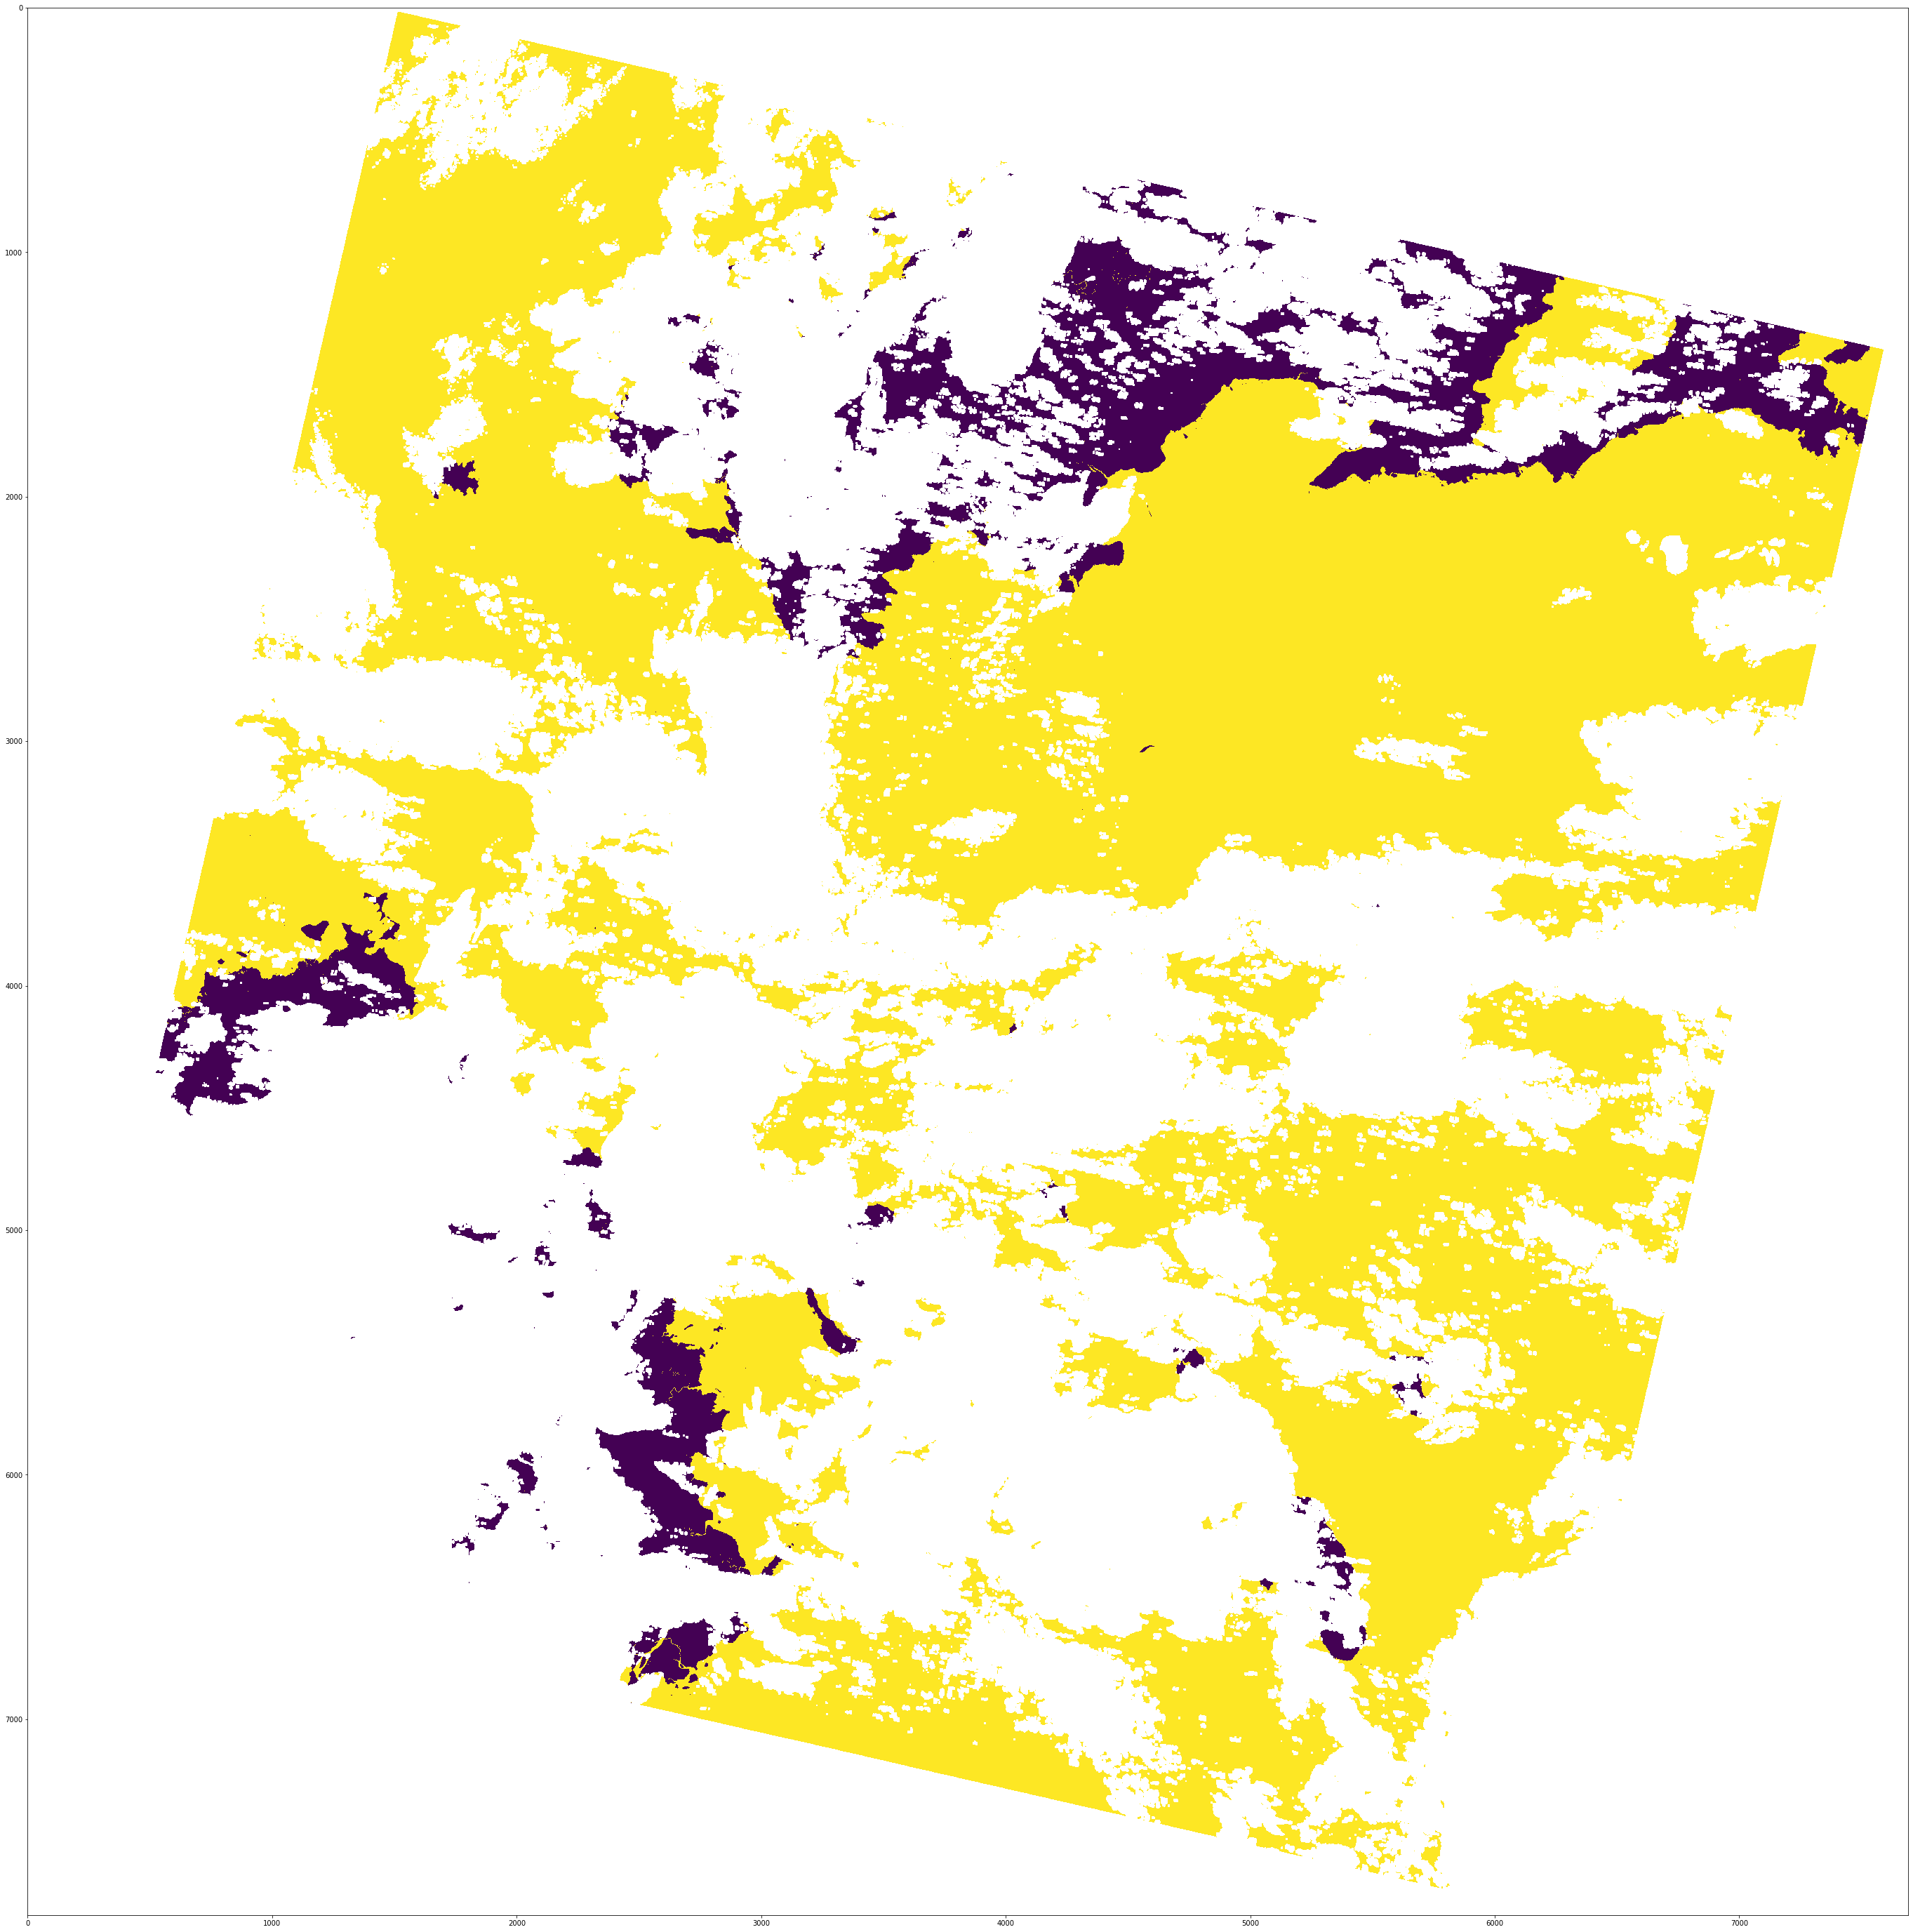

In [205]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(X_t.where(X_t.water_mask>=0).water_mask)

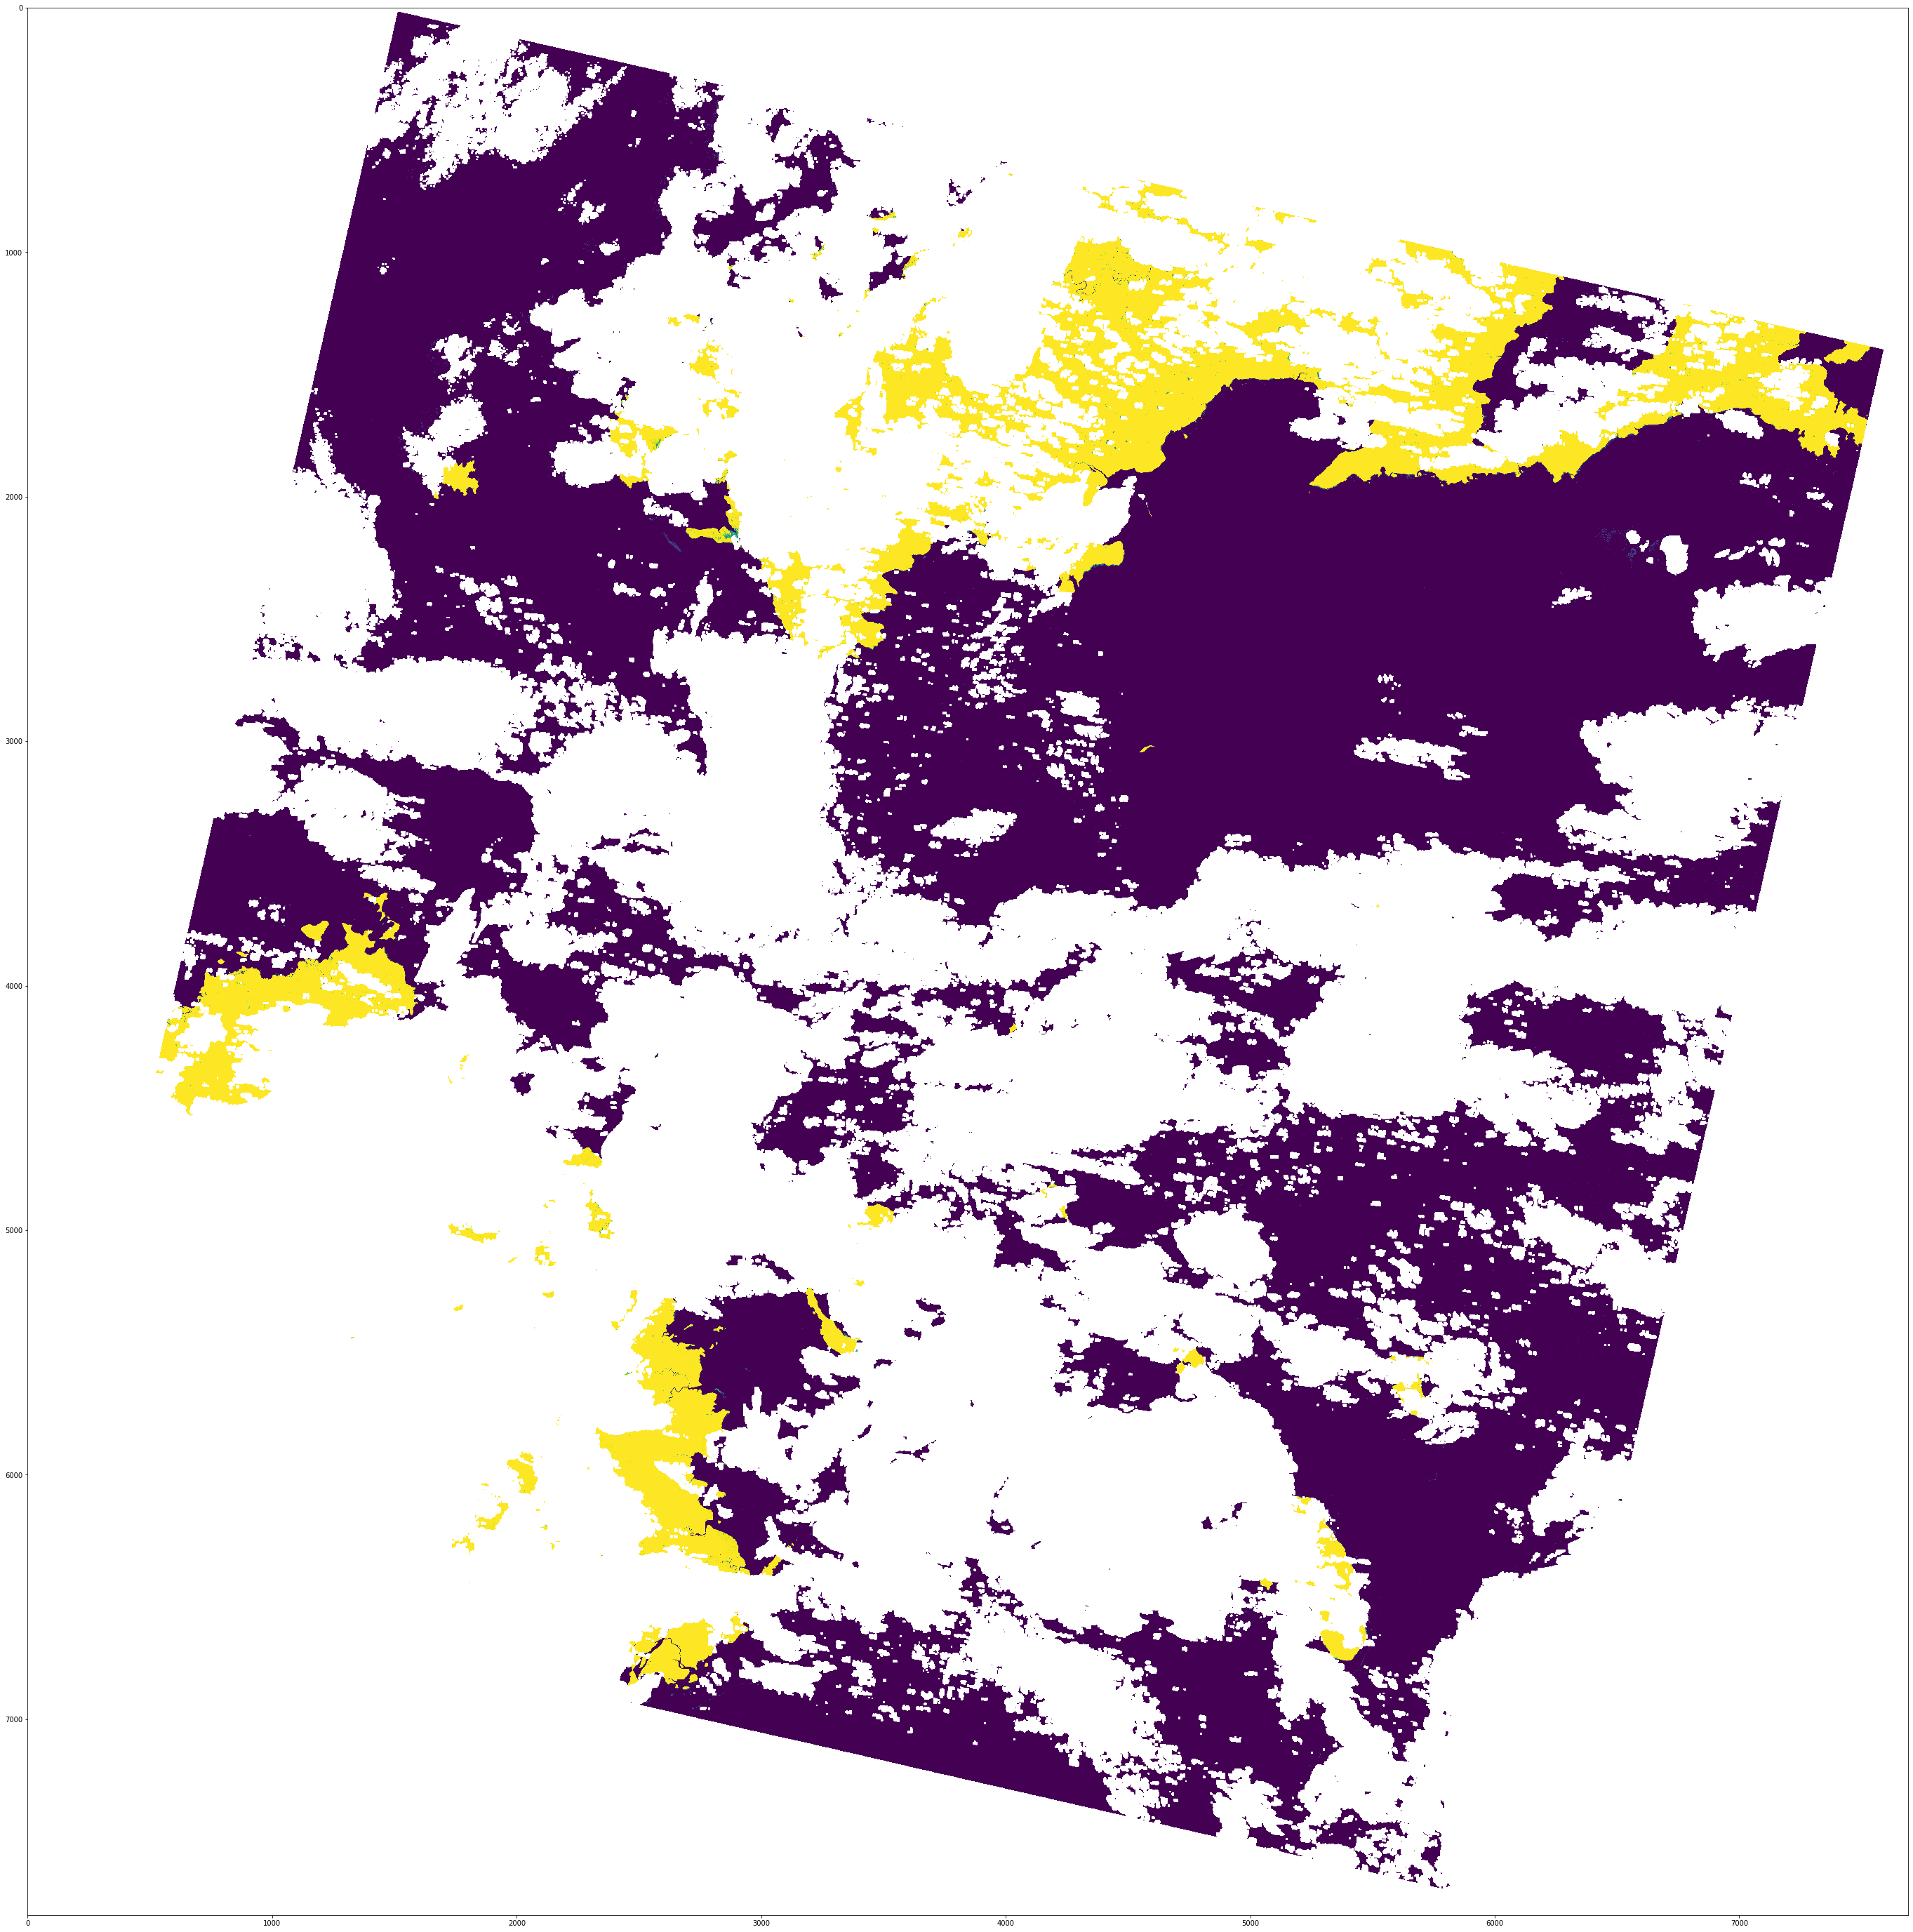

In [222]:
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(X_t.where(X_t.water_prob>=0).water_prob)